## LEXICON METHOD IMPLEMENTATION

In [32]:
import torch

In [33]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [34]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [35]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [2]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)


In [37]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [38]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [40]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project/Datasets/SEntFiN-v1.1.csv'
df = pd.read_csv(data_pth)
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8
...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5


#### PRE-PROCESSING STEPS IMPLEMENTED BELOW:-

In [41]:
def filter_rows_by_colon_count(data, column):
    """
    Filters out rows where the count of colons in the specified column exceeds one.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name in which colon count needs to be checked.

    Returns:
    - pd.DataFrame: DataFrame after filtering out specific rows.
    """
    condition = data[column].apply(lambda entry: str(entry).count(':') > 1)
    return data[~condition]

In [42]:
df = filter_rows_by_colon_count(df, 'Decisions')
print(f"Post Filtering Stage-1 Step-1: Total Rows - {len(df)}")

Post Filtering Stage-1 Step-1: Total Rows - 7903


In [43]:
def transform_decision_data(data, column):
    """
    Transforms the specified column of the DataFrame by extracting 'Entity' and 'Polarity' 
    from a dictionary representation. Ensures that strings mimicking dictionaries are 
    converted to actual dictionaries.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name which contains dictionary or its string representation.

    Returns:
    - pd.DataFrame: Transformed DataFrame with 'Headlines', 'Entity', and 'Sentiment' columns.
    """
    data_copy = data.copy()
    
    # Convert string representation of dictionary to actual dictionary
    data_copy[column] = data_copy[column].apply(lambda item: ast.literal_eval(item) if isinstance(item, str) else item)
    
    # Extract key and value from the dictionary
    data_copy['Entity'] = data_copy[column].apply(lambda item: list(item.keys())[0] if isinstance(item, dict) else None)
    data_copy['Sentiment'] = data_copy[column].apply(lambda item: list(item.values())[0] if isinstance(item, dict) else None)
    
    return data_copy[['Title', 'Entity', 'Sentiment']].rename(columns={'Title': 'Headlines'})

processed_df = transform_decision_data(df, 'Decisions')

#Dropping the entity column as the rest have been set aside in the transform_decision_data
processed_df = processed_df.drop(columns=['Entity'])


print(f"Post Filtering Stage-1 Step-2: Total Rows - {len(processed_df)}")

Post Filtering Stage-1 Step-2: Total Rows - 7903


In [44]:
def check_missing_data(dataframe):
    """
    Checks and returns the number of missing values in each column of a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    - Series: Number of missing values for each column.
    """
    return dataframe.isnull().sum()

print("Missing Values:\n", check_missing_data(processed_df))
processed_df = processed_df.dropna()
print(f"Post Filtering Stage-2 Step-1: Total Rows - {len(processed_df)}")

Missing Values:
 Headlines    0
Sentiment    0
dtype: int64
Post Filtering Stage-2 Step-1: Total Rows - 7903


In [45]:
def refine_headlines(column):
    """
    Cleans and refines a given text column. The function lowercases the text, removes 
    HTML content, URLs, non-alphanumeric characters, and stopwords. It also lemmatises 
    each word for better text consistency.

    Parameters:
    - column (pd.Series): The column containing text data to be refined.

    Returns:
    - pd.Series: The refined column.
    """
    column = column.str.lower()
    
    # Check if text looks like filename or not
    def extract_text(text):
        if re.match(r'^[A-Za-z0-9_\-\.]+$', text):
            return text
        return BeautifulSoup(text, 'lxml').get_text()
    
    column = column.str.replace('http\S+|www.\S+|[^\w\s]', '', regex=True)
    
   # lemmatizer = WordNetLemmatizer()
   # stop_words = set(stopwords.words('english'))
   # column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    
    return column

processed_df['Headlines'] = refine_headlines(processed_df['Headlines'])
print(f"Post Filtering Stage-2 Step-2: Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-2: Total Rows - 7903


In [46]:
# Detect and remove duplicate rows from the DataFrame
duplicated_rows = processed_df[processed_df.duplicated()]
processed_df.drop_duplicates(inplace=True)
print(f"Post Filtering Stage-2 Step-3 Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-3 Total Rows - 7858


In [47]:
def display_sentiment_counts(dataframe, column_name='Sentiment'):
    """
    Displays the frequency and relative percentage of each sentiment value in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing sentiment data.
    - column_name (str, optional): The name of the column containing sentiment values. Default is 'Sentiment'.

    Prints:
    - Sentiment counts and their relative percentages.
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(processed_df)



Count of each sentiment:
positive    2830
neutral     2657
negative    2371
Name: Sentiment, dtype: int64
positive    36.014253
neutral     33.812675
negative    30.173072
Name: Sentiment, dtype: float64


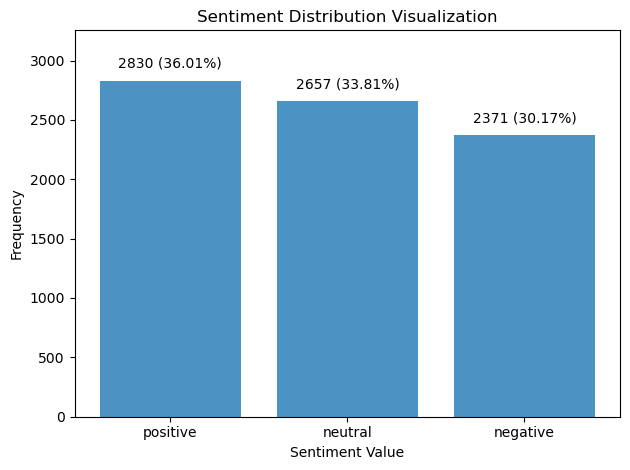

In [48]:
# Calculate and visualize the distribution of sentiment values in the DataFrame using a bar chart.
# Each bar is labelled with the sentiment count and its relative percentage.

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = processed_df['Sentiment'].value_counts()
sentiment_ratio = processed_df['Sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [49]:
#!pip install textblob

In [50]:
# --- Data Preparation ---

# Map the sentiments to numerical values
target_map = {'neutral':2,'positive':0,'negative':1}
processed_df = processed_df.copy()
processed_df.loc[:, 'Target'] = processed_df['Sentiment'].map(target_map)
processed_df.head()

,Headlines,Sentiment,Target
0,spicejet to issue 64 crore warrants to promoters,neutral,2
1,mmtc q2 net loss at rs 104 crore,neutral,2
2,midcap funds can deliver more stay put experts,positive,0
3,mid caps now turn into market darlings,positive,0
4,market seeing patience if not conviction praka...,neutral,2


In [51]:
# Extracting sentences and their labels
X, y = processed_df['Headlines'].values, processed_df['Target'].values

# Splitting the data into training, validation, and test sets (70-15-15 split)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [52]:
def display_report(Y_true, Y_pred, dataset_type="Training"):
    """
    Print out the classification report and display the confusion matrix.
    :param Y_true: true labels
    :param Y_pred: predicted labels
    :param dataset_type: a string specifying the dataset type ("Training", "Validation", or "Test")
    :return: None
    """
    # Print classification report
    print(f"{dataset_type} Classification Report:\n{classification_report(Y_true, Y_pred, digits=4)}\n")

    # Display the confusion matrix using a heatmap
    cm = confusion_matrix(Y_true, Y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    

In [1]:
def compute_FPR_spec_metrics(cm, labels=["positive", "negative", "neutral"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


In [53]:
def display_sentences(X, Y_true, Y_pred):
    """
    Display samples for true positives, true negatives, true neutrals, and the various false classifications.
    :param X: The text sentences
    :param Y_true: true labels
    :param Y_pred: predicted labels
    :return: None
    """    

    # Extracting sample indices for different scenarios
    true_positives = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == pred == 0]
    true_neutrals = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == pred == 2]
    true_negatives = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == pred == 1]

    # For false classifications
    false_positives_from_neutral = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 2 and pred == 0]
    false_positives_from_negative = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 1 and pred == 0]

    false_neutrals_from_positive = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 0 and pred == 2]
    false_neutrals_from_negative = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 1 and pred == 2]

    false_negatives_from_positive = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 0 and pred == 1]
    false_negatives_from_neutral = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 2 and pred == 1]

    # Displaying the samples
    print("True Positives:\n", [X[i] for i in true_positives[:5]])
    print("True Neutrals:\n", [X[i] for i in true_neutrals[:5]])
    print("True Negatives:\n", [X[i] for i in true_negatives[:5]])

    # Display the sentence and misclassifications
    print("\nFalse Positives (Neutral guessed as Positive):\n")
    for i in false_positives_from_neutral[:5]:
        print(f"Sentence: {X[i]}")
    
    print("\nFalse Positives (Negative guessed as Positive):\n")
    for i in false_positives_from_negative[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Neutrals (Positive guessed as Neutral):\n")
    for i in false_neutrals_from_positive[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Neutrals (Negative guessed as Neutral):\n")
    for i in false_neutrals_from_negative[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Negatives (Positive guessed as Negative):\n")
    for i in false_negatives_from_positive[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Negatives (Neutral guessed as Negative):\n")
    for i in false_negatives_from_neutral[:5]:
        print(f"Sentence: {X[i]}")


# TEXT BLOB IMPLEMENTATION

In [54]:
def analyze_sentiment(text):
    """
    Analyze sentiment of a given text using TextBlob's sentiment polarity.
    :param text: input text to be analyzed
    :return: sentiment label encoded as integer (0: positive, 1: negative, 2: neutral)
    """
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 0  # 'positive'
    elif analysis.sentiment.polarity == 0:
        return 2  # 'neutral'
    else:
        return 1  # 'negative'

In [55]:
# Predicting sentiments
Y_train_pred = [analyze_sentiment(text) for text in X_train]
Y_val_pred = [analyze_sentiment(text) for text in X_val]
Y_test_pred = [analyze_sentiment(text) for text in X_test]

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.4768    0.2743    0.3482       412
           1     0.5714    0.2372    0.3352       371
           2     0.3541    0.7045    0.4713       396

    accuracy                         0.4071      1179
   macro avg     0.4674    0.4053    0.3849      1179
weighted avg     0.4653    0.4071    0.3855      1179




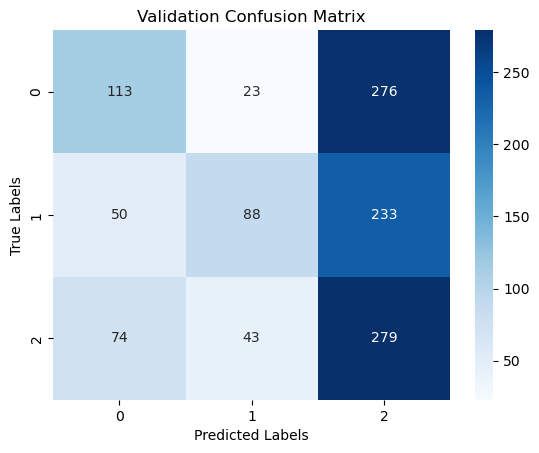

Test Classification Report:
              precision    recall  f1-score   support

           0     0.4656    0.2632    0.3363       437
           1     0.6230    0.3229    0.4254       353
           2     0.3538    0.6812    0.4657       389

    accuracy                         0.4190      1179
   macro avg     0.4808    0.4224    0.4091      1179
weighted avg     0.4758    0.4190    0.4057      1179




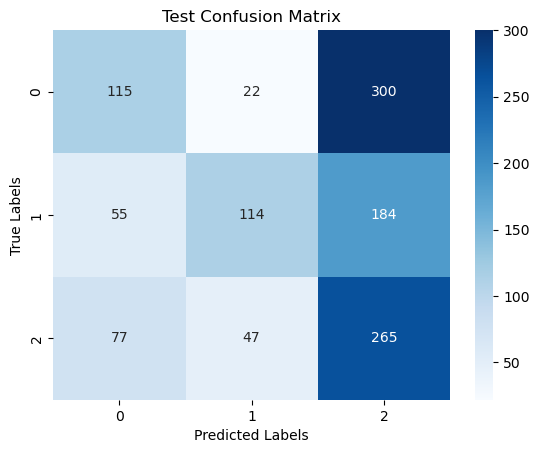

In [56]:
# Evaluating on the validation and test sets
display_report(Y_val, Y_val_pred, "Validation")
display_report(Y_test, Y_test_pred, "Test")

In [3]:
#Manually enter the matrix to get results about the specificity and FPR(Although it will remain the same if there are no changes to the dataset and split)
cm = np.array([[115, 22, 300], 
               [55, 114, 184], 
               [77, 47, 265]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.7417
FPR: 0.2583
Precision: 0.4656

Metrics for class negative (Class value: 1):
Specificity: 0.8463
FPR: 0.1537
Precision: 0.623

Metrics for class neutral (Class value: 2):
Specificity: 0.3212
FPR: 0.6788
Precision: 0.3538

Overall accuracy: 0.419
Weighted average specificity: 0.6343
Weighted average FPR: 0.3657
Macro average specificity: 0.6364
Macro average FPR: 0.3636



In [57]:
# Evaluating on the validation and test sets
display_sentences(X_test, Y_test, Y_test_pred)

True Positives:
 ['jindal steel looking strong on the back of good earnings avinnash gorakssakar', 'comfortable to buy airtel at 320350 levels sajiv dhawan', 'atul ltd rallies over 5 hits 52week high on stake sale reports', 'gspl surges hits 52week high on betterthanexpected q1 numbers', 'mindtree on course to join 1bn revenue club in next 5 years but present valuations fairly rich girish pai']
True Neutrals:
 ['micromax hopes to hit market soon with ipo', 'dhunseri petrochem and tea posts q4 pat at rs 2508 crore', 'kapil kapoor is global coo of timex group', 'union budget 201213 power cos trading mixed on ecb fuel supply decision', 'sebi board approves sharing kyc details with financial regulators']
True Negatives:
 ['jgbs edge down as investors monitor greek situation', 'hul shares down over 3 post q4 earnings', 'world stocks down on weak data wall street dive', 'potato futures down 076 on weak demand', 'copper softens in futures trade on weak global cues']

False Positives (Neutral 

# VADER IMPLEMENTATION

In [58]:
# --- Sentiment Analysis using VADER ---

sia = SentimentIntensityAnalyzer()

def analyze_vader_sentiment(text):
    """
    Analyze the sentiment of a text using VADER's polarity scores.
    :param text: A string containing the text to be analyzed.
    :return: An integer representing the sentiment (0 for positive, 1 for negative, 2 for neutral).
    """
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 0  # 'positive'
    elif score < -0.05:
        return 1  # 'negative'
    else:
        return 2  # 'neutral'

In [59]:
# Predict sentiments for the datasets
Y_train_pred = [analyze_vader_sentiment(text) for text in X_train]
Y_val_pred = [analyze_vader_sentiment(text) for text in X_val]
Y_test_pred = [analyze_vader_sentiment(text) for text in X_test]


Validation Classification Report:
              precision    recall  f1-score   support

           0     0.4931    0.5170    0.5047       412
           1     0.6653    0.4447    0.5331       371
           2     0.4228    0.5328    0.4715       396

    accuracy                         0.4996      1179
   macro avg     0.5271    0.4982    0.5031      1179
weighted avg     0.5237    0.4996    0.5025      1179




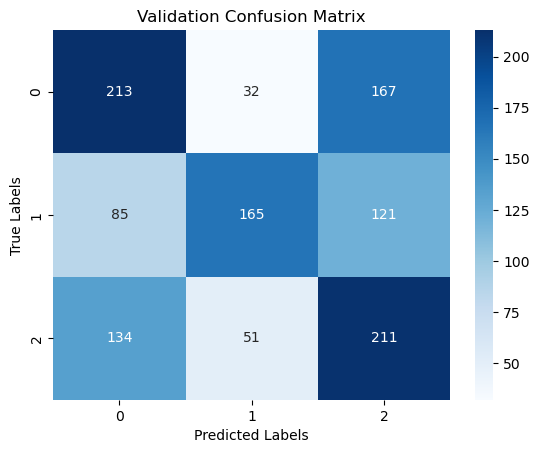

Test Classification Report:
              precision    recall  f1-score   support

           0     0.5159    0.5195    0.5177       437
           1     0.6942    0.4051    0.5116       353
           2     0.4221    0.5784    0.4881       389

    accuracy                         0.5047      1179
   macro avg     0.5441    0.5010    0.5058      1179
weighted avg     0.5383    0.5047    0.5061      1179




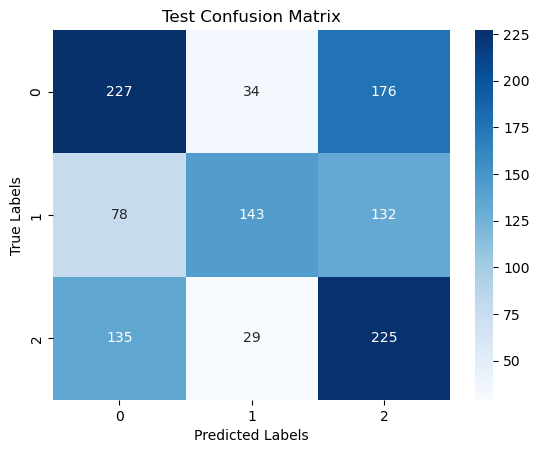

In [60]:
# Evaluating on the validation and test sets
display_report(Y_val, Y_val_pred, "Validation")
display_report(Y_test, Y_test_pred, "Test")

In [4]:
#Manually enter the matrix to get results about the specificity and FPR(Although it will remain the same if there are no changes to the dataset and split)
cm = np.array([[227, 34, 176], 
               [78, 143, 132], 
               [135, 29, 225]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.6334
FPR: 0.3666
Precision: 0.5159

Metrics for class negative (Class value: 1):
Specificity: 0.8777
FPR: 0.1223
Precision: 0.6942

Metrics for class neutral (Class value: 2):
Specificity: 0.5457
FPR: 0.4543
Precision: 0.4221

Overall accuracy: 0.5047
Weighted average specificity: 0.6776
Weighted average FPR: 0.3224
Macro average specificity: 0.6856
Macro average FPR: 0.3144



In [61]:
# Evaluating on the validation and test sets
display_sentences(X_test, Y_test, Y_test_pred)

True Positives:
 ['jindal steel looking strong on the back of good earnings avinnash gorakssakar', 'ivrcl rallies 5 as cdr approves rs 7000crore debt recast proposal', 'comfortable to buy airtel at 320350 levels sajiv dhawan', 'hdfc likely to report 10 growth in q3 net profit', 'yum beats q3 profit expectations']
True Neutrals:
 ['sebi to consider new corporate governance code tomorrow', 'dhunseri petrochem and tea posts q4 pat at rs 2508 crore', 'kapil kapoor is global coo of timex group', 'meher pudumjee is the new chairperson for ciipune', 'yuan firms for 4th week crosses 200day moving average']
True Negatives:
 ['gold trades near 4month low before european central bank decision us data', 'china shares post biggest daily loss in six months on economy liquidity worries', 'ample supply profitbooking hurt chana futures shed 236', 'auto stocks under pressure as october sales disappoint', 'unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12']

False Positives (Neutral guessed 